# Table of contents
1. [Introduction](#introduction)
2. [Analysis](#paragraph1)
    1. [Sex](#subparagraph1)
    2. [Age](#subparagraph2)
    3. [Cholestoral](#subparagraph3)
3. [Model](#paragraph2)



## Introduction <a name="introduction"></a>

Some introduction text, formatted in heading 2 style


### Context
This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.

### Attribute Information:

- age
- sex
- chest pain type (4 values)
- resting blood pressure
- serum cholestoral in mg/dl
- fasting blood sugar > 120 mg/dl
- resting electrocardiographic results (values 0,1,2)
- maximum heart rate achieved
- exercise induced angina
- oldpeak = ST depression induced by exercise relative to rest
- the slope of the peak exercise ST segment
- number of major vessels (0-3) colored by flourosopy
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- target=0 or 1 (no heart disease or heart disease)

## Acknowledgements
Creators:

- Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
- University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
- University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
- V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.
Donor:
- David W. Aha (aha '@' ics.uci.edu) (714) 856-8779

https://www.kaggle.com/ronitf/heart-disease-uci

## Inspiration
Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

See if you can find any other trends in heart data to predict certain cardiovascular events or find any clear indications of heart health.

### Importing modules

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns; sns.set()
from sklearn.pipeline import make_pipeline

#### Data import and inspection

In [141]:
dataset = pd.read_csv('Heart.csv')
print(dataset.shape)
print('Original Dataset:',dataset.columns)
df = dataset.rename(columns={'trestbps': 'restbp', 'thalach': 'hrateach', 'ca':'mvessel', 'thal':'hrate'})
df.head()

(303, 14)
Original Dataset: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


,age,sex,cp,restbp,chol,fbs,restecg,hrateach,exang,oldpeak,slope,mvessel,hrate,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Seeing how the target (y) is distributed

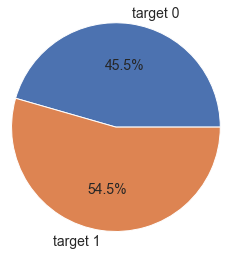

In [128]:
df_target = df.groupby("target").size()
plt.pie(df_target.values, labels = ["target 0", "target 1"], autopct='%1.1f%%', radius = 1.2, textprops = {"fontsize" : 14}) 
plt.show()

##### Observation: 
- The target is not skewed significantly with more than 50% diagnosed with heart disease

### Data Cleaning

In [129]:
#print(df.dtypes)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   restbp    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   hrateach  303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  mvessel   303 non-null    int64  
 12  hrate     303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


All data types are consistent, numeric and there no need for further conversion or null dropping.

Checking for missing values through missingno:
- Missingno is a Python library that provides the ability to understand the distribution of missing values through informative visualizations

<AxesSubplot:>

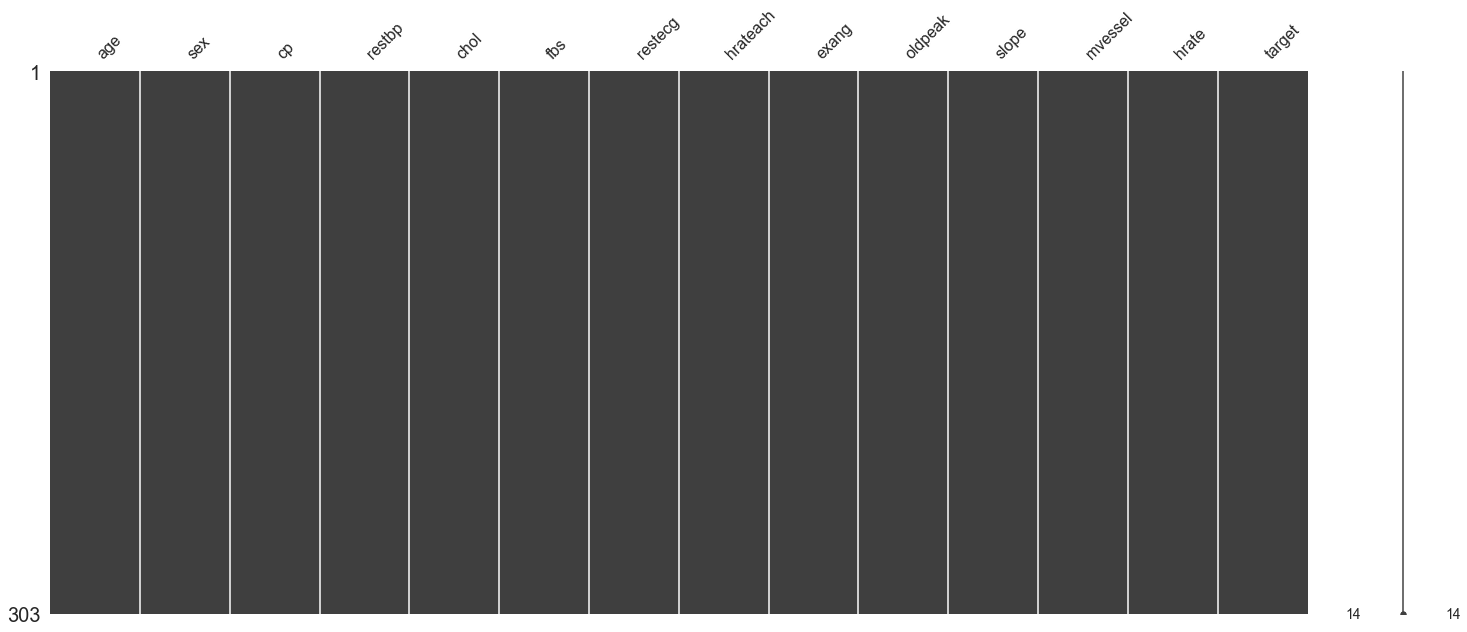

In [130]:
# !pip install missingno
import missingno as msno
msno.matrix(df)

##### Observation: 
No missing values

Histograms of each feature (inspecting for outliers, values, distribution):

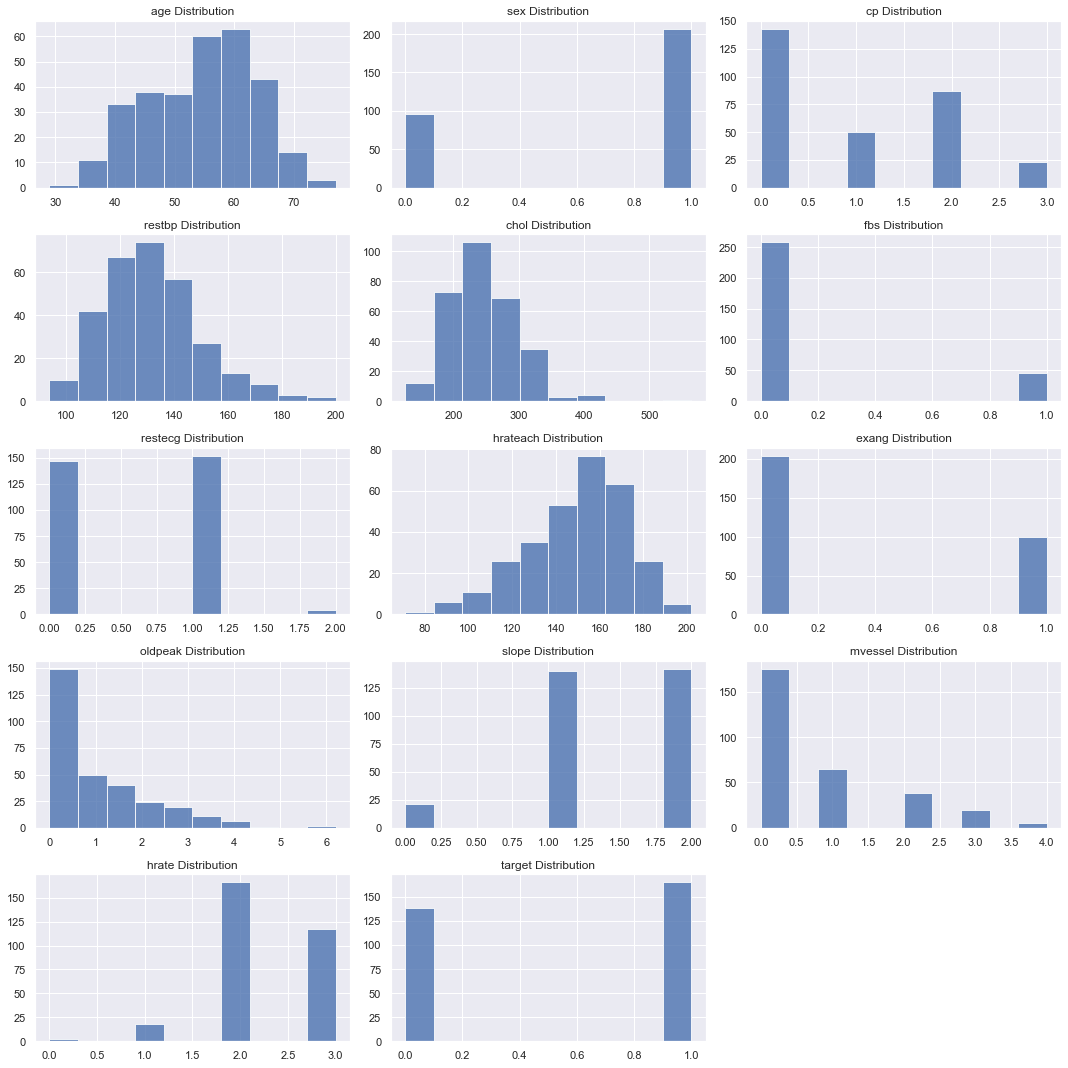

In [131]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15,15))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax, alpha=0.8)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(df, df.columns, 5, 3)
# X = dataset['chol']
# ax = X.hist(bins=15, alpha=0.5)

Correlation of different features

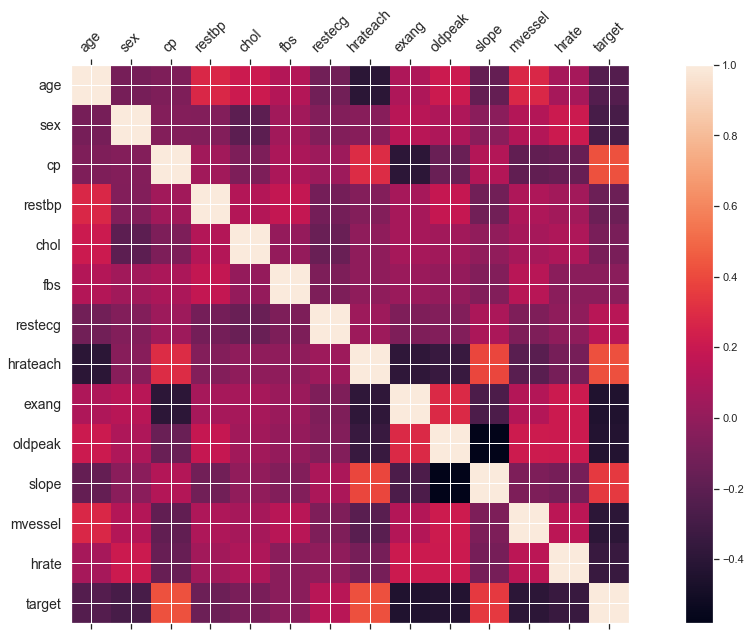

In [132]:
corr=df.corr(method='pearson').round(2)

plt.figure(figsize=(20,10))
plt.matshow(corr,fignum=1)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)

cb = plt.colorbar()

Sorting features based on their correlation to target value:

<AxesSubplot:>

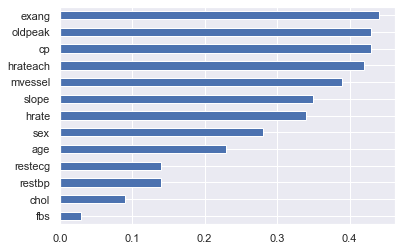

In [133]:
abs(corr['target']).sort_values()[:-1].plot.barh()

Looks like the target is highly correlated with: (top 5)
1. Exercise induced angina
2. Old Peak
3. Chest Pain
4. maximum Heart rate achieved
5. Number of major blood vessels 

## Analysis <a name="paragraph1"></a>
Here we take a closer look at some of the commonly known features (among public opinion) and their heart disease distribution among them.
Such as:
- Gender
- Age
- Cholestoral

### Gender analysis: Male/Female <a name="subparagraph1"></a>
To see whether gender has a significant effect on the heart disease status, we plot the histogram of the target distribution among different genders.


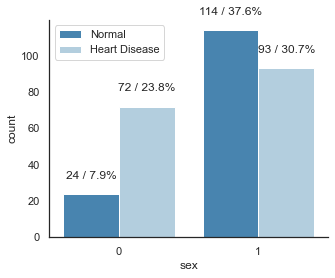

In [184]:
labels=['Normal','Heart Disease']
total_cnt = df['target'].count()
plt.figure(figsize=(5,4))
sns.set(font_scale = 1)
sns.set_style("white")
ax = sns.countplot(data=df, x='sex',hue='target',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=12)
plt.legend(labels=labels)

sns.despine()

Observation:
- Heart disease is more common among men (sex=1) than women

### Age analysis <a name="subparagraph2"></a>
Here we examine if heart disease has any trend or correlation with age

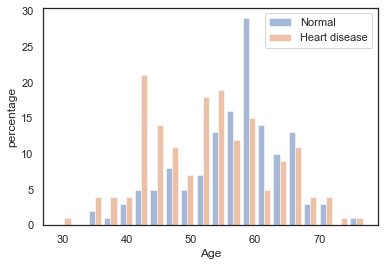

Average age of people with normal heart condition: 56.6
Average age of people with heart Disease: 52.5


In [190]:
plt.hist([df[df.target==0].age, df[df.target==1].age], bins = 20, alpha = 0.5, label = ["Normal","Heart disease"])
plt.xlabel("Age")
plt.ylabel("percentage")
plt.legend()
plt.show()
print('Average age of people with normal heart condition:',df[df.target==0].age.values.mean().round(2))
print('Average age of people with heart Disease:',df[df.target==1].age.values.mean().round(2))

Observation:
- Looks like the distribution of heart disease peaks around 52 years old 
- Age is not a major indicator of heart disease

### Cholestoral analysis (mg/dl) <a name="subparagraph3"></a>
Too much cholesterol – good or bad – can be harmful to the heart. High blood cholesterol can lead to "hardening of the arteries" and over time cause blood flow to and from the heart to slow down or become blocked. A person is considered at high risk for developing heart disease if their total cholesterol level is higher than 240 mg/dL, LDL levels are higher than 160 mg/dL (190 mg/dL is even higher risk), and if the HDL level is below 40 mg/dL.

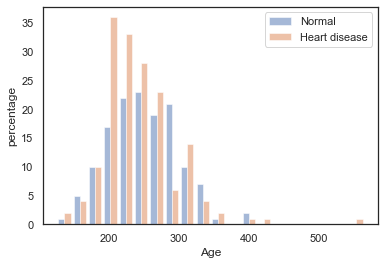

Average Cholestoral level of people with normal heart condition: 251.09
Average cholestoral level of people with heart Disease: 242.23


In [193]:
plt.hist([df[df.target==0].chol, df[df.target==1].chol], bins = 20, alpha = 0.5, label = ["Normal","Heart disease"])
plt.xlabel("Age")
plt.ylabel("percentage")
plt.legend()
plt.show()
print('Average Cholestoral level of people with normal heart condition:',df[df.target==0].chol.values.mean().round(2))
print('Average cholestoral level of people with heart Disease:',df[df.target==1].chol.values.mean().round(2))

## Model <a name="paragraph2"></a>

Since target value (heart disease=1 or 0) is binary, and the features are all numeric, the problem is a binary classification with small set of data (303 dataset, 14 features).
We build the model pipeline as below:
- preparing the datasets (choose X, Y)
- Train/test data split
- Standardize X features (normalize, centralize)
- Choose algorithms for classification
- Predict target vaoues for X-test
- Compare different model results (confusion matrix)

Preparing the feature values: mapping multiclass features via one-hot encoding

In [196]:
df_new=df.copy()
df_new.head()

,age,sex,cp,restbp,chol,fbs,restecg,hrateach,exang,oldpeak,slope,mvessel,hrate,target
0,63,1,non-anginal pain,145,233,1,0,150,exercise did not induce angina,2.3,flat,0,normal,1
1,37,1,atypical angina,130,250,0,1,187,exercise did not induce angina,3.5,flat,0,fixed defect,1
2,41,0,typical angina,130,204,0,0,172,exercise did not induce angina,1.4,downsloping,0,fixed defect,1
3,56,1,typical angina,120,236,0,1,178,exercise did not induce angina,0.8,downsloping,0,fixed defect,1
4,57,0,asymptomatic,120,354,0,1,163,exercise induced angina,0.6,downsloping,0,fixed defect,1


In [148]:
df_new.cp = df_new.cp.map({0:"asymptomatic", 1: "typical angina", 2:"atypical angina", 3:"non-anginal pain"})
df_new.exang = df_new.exang.map({0:"exercise did not induce angina", 1:"exercise induced angina"})
df_new.slope = df_new.slope.map({0:"flat", 1:"upsloping", 2:"downsloping"})
df_new.hrate = df_new.hrate.map({1:"normal",2:"fixed defect", 3:"reversable defect"})
df_new = pd.get_dummies(df_new, drop_first = True)
df_new.head(10)

,age,sex,restbp,chol,fbs,restecg,hrateach,oldpeak,mvessel,target,cp_atypical angina,cp_non-anginal pain,cp_typical angina,exang_exercise induced angina,slope_flat,slope_upsloping,hrate_normal,hrate_reversable defect
0,63,1,145,233,1,0,150,2.3,0,1,0,1,0,0,1,0,1,0
1,37,1,130,250,0,1,187,3.5,0,1,1,0,0,0,1,0,0,0
2,41,0,130,204,0,0,172,1.4,0,1,0,0,1,0,0,0,0,0
3,56,1,120,236,0,1,178,0.8,0,1,0,0,1,0,0,0,0,0
4,57,0,120,354,0,1,163,0.6,0,1,0,0,0,1,0,0,0,0
5,57,1,140,192,0,1,148,0.4,0,1,0,0,0,0,0,1,1,0
6,56,0,140,294,0,0,153,1.3,0,1,0,0,1,0,0,1,0,0
7,44,1,120,263,0,1,173,0.0,0,1,0,0,1,0,0,0,0,1
8,52,1,172,199,1,1,162,0.5,0,1,1,0,0,0,0,0,0,1
9,57,1,150,168,0,1,174,1.6,0,1,1,0,0,0,0,0,0,0


In [153]:
col=list(df_new.columns.values)
df_new = df_new.reindex(columns=['age','restbp','chol','hrateach','oldpeak',
 'mvessel',
 'target',
 'cp_atypical angina',
 'cp_non-anginal pain',
 'cp_typical angina',
 'exang_exercise induced angina',
 'slope_flat',
 'slope_upsloping',
 'hrate_normal',
 'hrate_reversable defect','sex','fbs','restecg',])
df_new.head()

,age,restbp,chol,hrateach,oldpeak,mvessel,target,cp_atypical angina,cp_non-anginal pain,cp_typical angina,exang_exercise induced angina,slope_flat,slope_upsloping,hrate_normal,hrate_reversable defect,sex,fbs,restecg
0,63,145,233,150,2.3,0,1,0,1,0,0,1,0,1,0,1,1,0
1,37,130,250,187,3.5,0,1,1,0,0,0,1,0,0,0,1,0,1
2,41,130,204,172,1.4,0,1,0,0,1,0,0,0,0,0,0,0,0
3,56,120,236,178,0.8,0,1,0,0,1,0,0,0,0,0,1,0,1
4,57,120,354,163,0.6,0,1,0,0,0,1,0,0,0,0,0,0,1


In [154]:
X = df_new.drop("target", 1).values
y = df_new['target']
X

array([[ 63., 145., 233., ...,   1.,   1.,   0.],
       [ 37., 130., 250., ...,   1.,   0.,   1.],
       [ 41., 130., 204., ...,   0.,   0.,   0.],
       ...,
       [ 68., 144., 193., ...,   1.,   1.,   1.],
       [ 57., 130., 131., ...,   1.,   0.,   1.],
       [ 57., 130., 236., ...,   0.,   0.,   0.]])

Normalize features and split Train Test Data (80/20)

In [161]:
from sklearn.preprocessing import StandardScaler
X1=X[:,0:4] # numerical features that need normalization
sc = StandardScaler()
X1 = sc.fit_transform(X1)
X[:,0:4]=X1
X[:2,:]

array([[ 0.9521966 ,  0.76395577, -0.25633371,  0.01544279,  2.3       ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         1.        ,  0.        ],
       [-1.91531289, -0.09273778,  0.07219949,  1.63347147,  3.5       ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ]])

In [158]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#X[:,0] = le.fit_transform(X[:,0])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

Algorithms for Classification

- Logistic Regeression 
- Naive Bayes

#### Logistic Regression

In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
y_pred_LR = LR.predict(X_test)
y_pred_LR

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0])

#### Naive Bayes

In [163]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

y_pred_NB  =  classifier.predict(X_test)
y_pred_NB

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1])

##### Confusion Matrix and Accuracy

In [197]:
from sklearn.metrics import confusion_matrix,accuracy_score

ac_LR = accuracy_score(y_test,y_pred_LR)
ac_NB = accuracy_score(y_test,y_pred_NB)
print('NB Accuracy score is {}'.format(ac_NB))
print('LR Accuracy score is {}'.format(ac_LR))

NB Accuracy score is 0.8360655737704918
LR Accuracy score is 0.819672131147541


Naive Bayes algorithm provides a higher accuracy

Confusion Matrix:

Text(80.90000000000006, 0.5, 'Predicted')

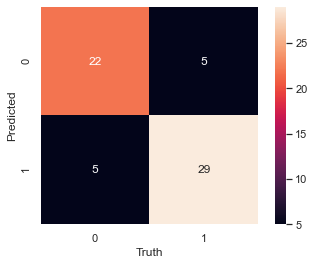

In [199]:
cm_NB = confusion_matrix(y_test, y_pred_NB)
names_NB = np.unique(y_pred_NB)
sns.heatmap(cm_NB, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=names, yticklabels=names_NB)
plt.xlabel('Truth')
plt.ylabel('Predicted')

In [207]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_NB).ravel()
precision_rate = tp / (tp + fp)
recall_rate = tp / (tp + fn)

print("The precision rate is: ", precision_rate)
print("The recall rate is: ", recall_rate)

The precision rate is:  0.8529411764705882
The recall rate is:  0.8529411764705882


Here, because of severity of heart disease and the high risk of mortality, false negatives can have high consequences